In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay
import numpy as np
import random
from copy import deepcopy
from collections import Counter
from pprint import pprint
from tqdm import tqdm
from collections import deque
import os
import pickle
Delauney = Delaunay # sorry...

In [52]:
def mean(s):
    return sum(s) / len(s)

def random_points(N, gauss_n = 5, gauss_p = .7, base_scale = 2):
    gaussians = []
    for _ in range(gauss_n):
        locx = np.random.uniform(42) + 4
        locy = np.random.uniform(42) + 4
        scale = base_scale
        gaussians.append(((locx, locy), scale))
    points = []
    while len(points) < N:
        if np.random.random() < gauss_p:
            g = random.choice(gaussians)
            point = [-1,-1]
            while not (0 < point[0] < 50 and 0 < point[1] < 50):
                point = [np.random.normal(g[0][0], g[1]), np.random.normal(g[0][1], g[1])]
            points.append(point)
        else:
            points.append([np.random.uniform(50), np.random.uniform(50)])
            
    return points

def random_planar(N, gauss_n = 5, gauss_p = .7, base_scale = 2):
    points = random_points(N, gauss_n, gauss_p, base_scale)
    tri = Delauney(points)
    G = nx.Graph()
    for i, coords in enumerate(tri.points):
        G.add_node(i, coords=coords)

    for simplex in tri.simplices:
        G.add_edge(simplex[0], simplex[1])
        G.add_edge(simplex[0], simplex[2])
        G.add_edge(simplex[1], simplex[2])
    
    
    return G


In [38]:
def euclid_dist(n1, n2):
    """Pythagoras"""
    return ((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2 ) **.5

def cull_edges(G):
    # remove unrealistically long roads
    attributes = nx.get_node_attributes(G, 'coords')
    removal = []
    for edge in G.edges:
        if 20 < euclid_dist(attributes[edge[0]], attributes[edge[1]]):
            removal.append(edge)
            
    for edge in removal:
        G.remove_edge(*edge)
            
    print("Estimating betweenness")
    # get degrees below 5
    betweenness = nx.algorithms.centrality.edge_betweenness_centrality(G, k=min(100, len(G)))
    print('Culling edges')
    for node in G:
        if G.degree[node] > 4:
            edges_with_betweenness = []
            for e in G.edges(node):
                edges_with_betweenness.append((betweenness[tuple(sorted(e))], e))
            edges_with_betweenness.sort()
            for b, e in edges_with_betweenness[:-4]:
                G.remove_edge(*e)
                
    # remove nodes with degree 2
    change = True
    while change:
        change=False
        for node in deepcopy(G.nodes):
            if G.degree(node) == 2:
                neigh = list(G.neighbors(node))
                G.add_edge(neigh[0], neigh[1])
                G.remove_node(node)
                change=True
    
    # remove node with degree 0
    for node in deepcopy(G.nodes):
        if G.degree(node) == 0:
            G.remove_node(node)
            
    for edge in deepcopy(G.edges):
        if G.degree(edge[0]) == 4:
            if G.degree(edge[1]) == 4:
                G.remove_edge(*edge)
    return G

In [39]:
def plot_graph(G):
    """Plot networkx graph. Whereby position is given by coords attribute"""
    plt.figure()

    # positions for all nodes
    pos = nx.get_node_attributes(G, "coords")

    # nodes
    nx.draw_networkx_nodes(G, pos = pos, node_size=1, node_color='r', node_shape='v')

    # colour edges based on their weights
    edges = G.edges()
    nx.draw_networkx_edges(G, pos = pos, edgelist=edges, width=.6)
    #nx.draw(G, pos = pos)

    #small_df.plot()
    plt.show()
    
def largest_comp(G):
    best = -1
    for x in nx.connected_component_subgraphs(G):
        size = len(x.nodes)
        if size > best:
            best = size
            G = x
    return G


def random_road_network(N, gauss_n=5, gauss_p=0.7, base_scale=2):
    print('Making random planar graph, and Delaunay triangulation')
    G = random_planar(N, gauss_n, gauss_p, base_scale)
    G = cull_edges(G)
    print('Getting the largest component')
    G = largest_comp(G)
    return G

Making random planar graph, and Delaunay triangulation
Estimating betweenness
Culling edges
4520
Getting the largest component


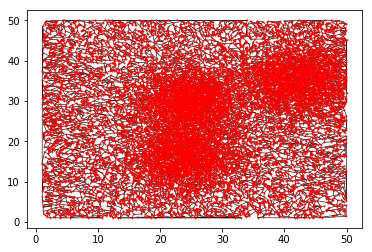

In [20]:
G = random_road_network(25000, 3, .5, 3)
plot_graph(G)

## Comparisons

#### FIrst cell is all the functions

In [98]:
def estimate_ave_path_length(G, N):
    means = []
    running_mean = []
    nodes = list(G.nodes)
    nodes = random.sample(nodes, N)
    for node in tqdm(nodes):
        new = list(nx.single_source_dijkstra_path_length(G, node).values())
        means.append(mean(new))
        running_mean.append(mean(means))
    return running_mean[-1], running_mean

def remove_useless_nodes(G):
    """
    Removes (in-place) nodes with degree 2 but preserves connectivity
    """
    while list(dict(G.degree()).values()).count(2):
        deg = dict(G.degree())
        for node in deg:
            if deg[node] == 2:
                neigh = list(G.neighbors(node))
                if len(neigh) == 1:
                    break
                G.add_edge(neigh[0], neigh[1])
                G.remove_node(node)
    return G

def get_neighborhood(center, G):
    n_nodes = len(G) // 250 + 1
    q = deque()
    q.append(center)
    result = set()
    while len(result) < n_nodes and q:
        a = q.popleft()
        result.add(a)
        for neigh in G.neighbors(a):
            if neigh not in result:
                q.append(neigh)
    return result

def max_flow_neighborhood(G, sourcecoords=None, sinkcoords=None, radius=1, flowattr='flow', spatial = True):
    """
    Takes a graph, and chooses a source and sink randomly unless gives. Calculates and returns 
    max flow between source and sink.
    """
    assert (sourcecoords is None and sinkcoords is None) or (sourcecoords and sinkcoords), "Either both source and sink have to be given, or neither."
    
    if spatial:
        if sourcecoords is None:
            dist = float('-inf')
            while dist < radius * 2:
                sourcecenter = random.choice(list(G.nodes))
                sourcecoords = G.node[sourcecenter]['coords']

                sinkcenter = random.choice(list(G.nodes))
                sinkcoords = G.node[sinkcenter]['coords']

                dist = euclid_dist(sourcecoords, sinkcoords)
        else:
            assert euclid_dist(sourcecoords, sinkcoords) > radius * 2, "Source and sink ranges overlap."

        G.add_node('SOURCE')
        G.add_node('SINK')

        for node in G:
            if node == 'SOURCE' or node == 'SINK':
                continue
            if euclid_dist(G.node[node]['coords'], sourcecoords) < radius:
                G.add_edge('SOURCE', node, flowattr = 10**20) # infinite, but float('inf') might not work
            if euclid_dist(G.node[node]['coords'], sinkcoords) < radius:
                G.add_edge('SINK', node, flowattr = 10**20)

    else:
        source=set([1])
        sink=[1]
        while not source.isdisjoint(sink):
            sourcecenter = random.choice(list(G.nodes))
            sinkcenter = random.choice(list(G.nodes))
            source = get_neighborhood(sourcecenter, G)
            sink = get_neighborhood(sinkcenter, G)
            
        G.add_node('SOURCE')
        G.add_node('SINK')
        
        for node in source:
            G.add_edge('SOURCE', node, flowattr = 10**20)
        for node in sink:
            G.add_edge('SINK', node, flowattr = 10**20)
    try:
        max_flow, flow = nx.maximum_flow(G, 'SOURCE', 'SINK', capacity=flowattr)
    except:
        print(set(G.neighbors('SOURCE')) & set(G.neighbors('SINK')))
        print(G.edges('SOURCE'))
        1/0
    G.remove_node('SINK')
    G.remove_node('SOURCE')
    return max_flow, flow

def max_flow_iteration(G, N, inc_ratio_func, radius=1, flowattr='flow', copy=True, continent_name="Australia", spatial=True):
    """
    Calls max_flow_neighborhood N times, using the flow to increase capacity
    of roads of which flow was used, and normalizes. Returns the max flow of
    each iteration and the resulting graph.
    """
    if copy:
        G = deepcopy(G)

    max_flow_prog = []
    for n in tqdm(range(N)):
        if not n % 100:
            save_graph(G, continent_name, str(n))
        
        max_flow, flow = max_flow_neighborhood(G, spatial=spatial)
        max_flow_prog.append(max_flow)
        
        done = set()
        
        for key1 in flow:
            if key1 in ['SOURCE', 'SINK']:
                continue
            for key2 in flow[key1]:
                if key2 in ['SOURCE', 'SINK'] or (key2, key1) in done:
                    continue
                f = flow[key1][key2]
                if f > 0:
                    max_flow = G[key1][key2]['flow']
                    G[key1][key2]['flow'] += inc_ratio_func(n) * f / max_flow
                done.add((key1, key2))
        flows = nx.get_edge_attributes(G, 'flow')
        frac = sum(flows.values()) / len(flows)
        flows.update((x,y/frac) for x, y in flows.items())
        nx.set_edge_attributes(G, flows, 'flow')
    
    save_graph(G, continent_name, "FinalResult")
    return max_flow_prog, G

def save_graph(G, name, it):
    if not os.path.exists('Graph_GPickles'):
        os.makedirs('Graph_GPickles')
    nx.write_gpickle(G, "./Graph_GPickles/{}_{}.gpickle".format(name, it))

## Here we make the graph

In [71]:
random_road = random_road_network(25000, 3, .5, 3)
small_world = nx.watts_strogatz_graph(20000, 4, 0.1)
p = 2 * len(random_road.edges) / (len(random_road) * (len(random_road) - 1))
random_erdos = nx.fast_gnp_random_graph(25000, p)
scale_free = nx.barabasi_albert_graph(40000, 2)

random_graphs = {
    "randomroad": random_road, "smallworld": small_world, "erdos": random_erdos, "scalefree": scale_free
}

In [72]:
for key in random_graphs:
    random_graphs[key] = largest_comp(random_graphs[key])
    random_graphs[key] = remove_useless_nodes(random_graphs[key])
    nx.set_edge_attributes(random_graphs[key], 1, 'flow')

In [73]:
for name, G in random_graphs.items():
    print('{}:'.format(name))
    print('Average path length: {}'.format(estimate_ave_path_length(G, 100)[0]))
    print('Number of nodes: {}'.format(len(G.nodes)))
    print('Clustering coefficient: {}'.format(nx.average_clustering(G)))
    print('Average degree: {}'.format(mean(dict(G.degree()).values())))
    print('Degree distribution:', end=' ')
    pprint(dict(Counter(list(dict(G.degree).values()))))


road:


100%|████████████████████████████████████████| 100/100 [00:08<00:00, 11.88it/s]


Average path length: 60.10430709106806
Number of nodes: 19447
Clustering coefficient: 0.10752301126137291
Average degree: 2.8856893094050498
Degree distribution: {1: 1914, 3: 15928, 4: 1605}
smallworld:


100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.88it/s]


Average path length: 13.806592491674238
Number of nodes: 19818
Clustering coefficient: 0.37315691843393556
Average degree: 4.00474316278131
Degree distribution: {3: 3057, 4: 13880, 5: 2624, 6: 247, 7: 8, 8: 1, 9: 1}
erdos:


100%|████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


Average path length: 7.218564578963144
Number of nodes: 20022
Clustering coefficient: 0.00028385442679718965
Average degree: 4.162521226650684
Degree distribution: {1: 2330,
 3: 5212,
 4: 4680,
 5: 3537,
 6: 2224,
 7: 1182,
 8: 531,
 9: 206,
 10: 80,
 11: 32,
 12: 5,
 13: 3}
scalefree:


100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Average path length: 4.4272932632106174
Number of nodes: 19965
Clustering coefficient: 0.0031853375639300918
Average degree: 5.998797896318558
Degree distribution: {3: 7987,
 4: 4031,
 5: 2255,
 6: 1359,
 7: 983,
 8: 671,
 9: 468,
 10: 395,
 11: 260,
 12: 232,
 13: 183,
 14: 139,
 15: 104,
 16: 97,
 17: 89,
 18: 66,
 19: 79,
 20: 56,
 21: 51,
 22: 30,
 23: 38,
 24: 36,
 25: 26,
 26: 27,
 27: 15,
 28: 20,
 29: 17,
 30: 18,
 31: 18,
 32: 14,
 33: 10,
 34: 9,
 35: 9,
 36: 11,
 37: 10,
 38: 5,
 39: 2,
 40: 4,
 41: 7,
 42: 10,
 43: 5,
 44: 7,
 45: 8,
 46: 3,
 47: 6,
 48: 3,
 49: 2,
 50: 3,
 51: 4,
 53: 3,
 54: 5,
 55: 2,
 56: 2,
 57: 3,
 58: 2,
 60: 4,
 61: 2,
 63: 1,
 64: 3,
 65: 1,
 66: 2,
 67: 2,
 70: 2,
 72: 3,
 74: 1,
 75: 3,
 77: 1,
 78: 1,
 79: 2,
 81: 1,
 84: 1,
 87: 2,
 88: 3,
 89: 2,
 91: 2,
 92: 1,
 93: 2,
 98: 1,
 101: 1,
 103: 1,
 104: 1,
 105: 1,
 113: 1,
 117: 1,
 118: 1,
 120: 1,
 126: 2,
 132: 1,
 161: 1,
 171: 1,
 183: 1,
 201: 2,
 251: 1,
 280: 1,
 303: 1,
 311: 1,
 339: 

In [ ]:
for name, G in random_graphs.items():
    if name[-4:].lower() != 'road':
        spatial = False
    else:
        spatial=True
    print(name)
    a, resulting_graph = max_flow_iteration(G, 1000, lambda x: 1/(5+x/100), continent_name = name, spatial=spatial)

    with open('./Graph_Gpickles/{}_MaxFlowList.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f)

road


  1%|▍                                       | 10/1000 [00:34<56:09,  3.40s/it]

In [100]:
for name, G in random_graphs.items():
    nx.write_gpickle(G, name+".gpickle", 2)